Проект нашей команды на второй тур отборочного этапа Сириус.ИИ.

Мы разработали сервис для оценки цены недвижимости. 
Для обучения модели нам необходимы качественные и обработанные данные.

Качество данных зависит не от нас (Верим Яндексу и ВШЭ ФКН), поэтому займёся предобработкой.

## Исследование данных.

В рамках дополнительного задания нам было предложено провести исследование данных с информацией о сделках с недвижимость в Москве за определённый период времени.

Анализ будем производить с помощью средств библиотек:
- pandas - управление данными
- seaborn - анализ графиков

In [1]:
# подключим необходимые библиотеки
import pandas as pd
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Простые функции для более выраженного кода.

def object_to_float(df, column):
    df[column] = df[column].astype(float)


def float_to_int(df, column):
    df[column] = df[column].astype(int)

## Шаги исследования.
- Обработка отсутствующих значени.
    
    Посмотрите на отсутствующие значения и подума те, стоит ли исключать строки с ними из датасета. Если нет, то нужно придумать решение, которое позволит обрабатывать отсутствующие значения в каждом из поле.
- Обработка лишних значений. 

    Выясните, какие значения можно убрать из датасета без потери информации. Ориентируйтесь на корреляцию между полями.

- Выявление аномали.

    Посмотрите на распределения значени , есть ли там выбросы и аномалии? Если да, то с чем они связаны и как их обработать?

- Сбалансированность.

    Проверьте, сбалансированы ли данные. Подума те, по каким признакам смотреть баланс.

- Базовы отбор признаков.

    Выясните, какие признаки влияют на целевую переменную – цену, а какие нет. Это можно сделать с помощью визуализаци . Можно изучать как отдельные признаки, так и их комбинации.

- Статистики.

    Посчита те основные статистики на основе данных, имеет смысл сделать это по годам. Сравните с современными данными по Москве (обязательно укажите, откуда брали современные данные).

### Обработка train.csv

In [3]:
train = pd.read_csv("data/train.csv", skipinitialspace=True, sep=',', decimal=',')

train.shape

(30471, 292)

In [4]:
train.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


In [5]:
train.dtypes

id                      int64
timestamp              object
full_sq                 int64
life_sq               float64
floor                 float64
                       ...   
mosque_count_5000       int64
leisure_count_5000      int64
sport_count_5000        int64
market_count_5000       int64
price_doc               int64
Length: 292, dtype: object

Заметим, что у нас около 300 признаков, на которых будет обучаться модель.
Некоторые из них имеют прямое влияние на ценообразование, некоторые другие могут совершенно не влиять.

Для более качественного анализа исключим сильно скоррелированные данные.

#### Обработка отсутствующих значений.
Заметим, что используемая нами модель не предназначена для обучения на данных с отсутствующими значениями. 

Поэтому нам придётся их обработать. Есть три пути решения данной проблемы:
1) Удаление пустых значений (записей, колонок) (drop)

    Плюсы:
    - Простое решение.
    
    Минусы:
    - Потеря данных. Количество данных, на которой будет обучатся модель, может сильно уменьшится. Поэтому будем выбирать между удалением строк(теряем данные) и столбцов(теряем характеристику).
2) Заполнение некоторым другим значением (медиана, мода, ср.ариф)

    Плюсы:
    - Не теряем данные.

    Минусы:
    - Заполнение данных может сильно повлиять на распределение и "запутать" модель.
    - Задача заполнения значений может оказаться трудной.

In [6]:
# слишком много пропусков, нужен для идентификации.
train = train.drop(columns=['life_sq', 'id'])

In [7]:
train.isna().sum()

timestamp                0
full_sq                  0
floor                  167
max_floor             9572
material              9572
                      ... 
mosque_count_5000        0
leisure_count_5000       0
sport_count_5000         0
market_count_5000        0
price_doc                0
Length: 290, dtype: int64

Подумав некоторое время, мы решили заполнить значения в пропусках медианным значениями, так как на наш взгяд, это самое хорошее решение.

##### Категориальные признаки.
Модель которая будет использована в дальнейшем не умеет обрабатывать категориальные признаки.
Поэтому разделим данные на категориальные и числовые, отдельно обработаем числовые и категориальные.

In [8]:
categorial_columns = train.dtypes[train.dtypes == 'object'].index.to_list()
numeric_columns = train.dtypes[train.dtypes != 'object'].index.to_list()

print(categorial_columns)
print(numeric_columns)

['timestamp', 'product_type', 'sub_area', 'area_m', 'green_zone_part', 'indust_part', 'culture_objects_top_25', 'thermal_power_plant_raion', 'incineration_raion', 'oil_chemistry_raion', 'radiation_raion', 'railroad_terminal_raion', 'big_market_raion', 'nuclear_reactor_raion', 'detention_facility_raion', 'metro_min_avto', 'metro_km_avto', 'metro_min_walk', 'metro_km_walk', 'kindergarten_km', 'school_km', 'park_km', 'green_zone_km', 'industrial_km', 'water_treatment_km', 'cemetery_km', 'incineration_km', 'railroad_station_walk_km', 'railroad_station_walk_min', 'railroad_station_avto_km', 'railroad_station_avto_min', 'public_transport_station_km', 'public_transport_station_min_walk', 'water_km', 'water_1line', 'mkad_km', 'ttk_km', 'sadovoe_km', 'bulvar_ring_km', 'kremlin_km', 'big_road1_km', 'big_road1_1line', 'big_road2_km', 'railroad_km', 'railroad_1line', 'zd_vokzaly_avto_km', 'bus_terminal_avto_km', 'oil_chemistry_km', 'nuclear_reactor_km', 'radiation_km', 'power_transmission_line_km'

Проанализировав имеющиеся категориальные признаки, мы заметили в них числовые характеристики.
С помощью следующего кода перведём их в числовой формат.

In [9]:
train['culture_objects_top_25'] = train['culture_objects_top_25'] == 'yes'

new_categorial_columns = []
for category in categorial_columns:
    if 'raion' in category or 'line' in category:
        train[category] = train[category] == 'yes'
        numeric_columns.append(category)
    elif '_km' in category or '00' in category or "_min" in category or "_part" in category or category == 'area_m':
        train[category] = train[category].astype(float)
        numeric_columns.append(category)
    elif category != 'culture_objects_top_25':
        new_categorial_columns.append(category)
categorial_columns = new_categorial_columns

print(categorial_columns)
print(numeric_columns)

['timestamp', 'product_type', 'sub_area', 'ecology']
['full_sq', 'floor', 'max_floor', 'material', 'build_year', 'num_room', 'kitch_sq', 'state', 'raion_popul', 'children_preschool', 'preschool_quota', 'preschool_education_centers_raion', 'children_school', 'school_quota', 'school_education_centers_raion', 'school_education_centers_top_20_raion', 'hospital_beds_raion', 'healthcare_centers_raion', 'university_top_20_raion', 'sport_objects_raion', 'additional_education_raion', 'culture_objects_top_25_raion', 'shopping_centers_raion', 'office_raion', 'full_all', 'male_f', 'female_f', 'young_all', 'young_male', 'young_female', 'work_all', 'work_male', 'work_female', 'ekder_all', 'ekder_male', 'ekder_female', '0_6_all', '0_6_male', '0_6_female', '7_14_all', '7_14_male', '7_14_female', '0_17_all', '0_17_male', '0_17_female', '16_29_all', '16_29_male', '16_29_female', '0_13_all', '0_13_male', '0_13_female', 'raion_build_count_with_material_info', 'build_count_block', 'build_count_wood', 'buil

In [10]:
# Заполняем пропуски медианным значением
for column in numeric_columns:
    if train[column].isnull().sum() != 0:
        train[column] = train[column].fillna(train[column].median())


#### Обработка лишних значений.
Выясните, какие значения можно убрать из датасета без потери информации. Ориентируйтесь на корреляцию между полями.

Сильно скоррелированные параметры взаимосвязаны между собой. Так, что они не дают новой информации, поэтому их можно удалить, не боясь потерять данные.

In [11]:
numeric_train = train[numeric_columns]

correlation_matrix = numeric_train.corr()

correlated_features = set()
for column in range(len(correlation_matrix.columns)):
    for j in range(column):
        if abs(correlation_matrix.iloc[column, j]) > 0.5:
            colname = correlation_matrix.columns[column]
            correlated_features.add(colname)

if 'price_doc' in correlated_features:
    correlated_features.remove('price_doc')
# Удаляем скоррелированные признаки из DataFrame
train = train.drop(correlated_features, axis=1)
# переприсваиваем числовые колонки
numeric_columns = train.dtypes[train.dtypes != 'object'].index.to_list()

In [12]:
numeric_columns

['full_sq',
 'floor',
 'max_floor',
 'material',
 'build_year',
 'num_room',
 'kitch_sq',
 'state',
 'area_m',
 'raion_popul',
 'school_education_centers_top_20_raion',
 'hospital_beds_raion',
 'university_top_20_raion',
 'culture_objects_top_25',
 'thermal_power_plant_raion',
 'incineration_raion',
 'oil_chemistry_raion',
 'radiation_raion',
 'big_market_raion',
 'nuclear_reactor_raion',
 'detention_facility_raion',
 'full_all',
 'build_count_block',
 'build_count_foam',
 'ID_metro',
 'metro_min_avto',
 'green_zone_km',
 'industrial_km',
 'cemetery_km',
 'ID_railroad_station_walk',
 'water_km',
 'water_1line',
 'big_road1_km',
 'ID_big_road1',
 'big_road1_1line',
 'ID_big_road2',
 'railroad_1line',
 'ID_railroad_terminal',
 'ID_bus_terminal',
 'power_transmission_line_km',
 'prom_part_500',
 'cafe_sum_500_min_price_avg',
 'mosque_count_500',
 'leisure_count_500',
 'market_count_500',
 'price_doc']

In [13]:
train.shape

(30471, 50)

#### Выявление аномалий.
Проанализируем распределение данных. 

Если в них будут выбросы то это может негативно сказаться на итоговом качестве модели.

Именно поэтому важно их удалять.

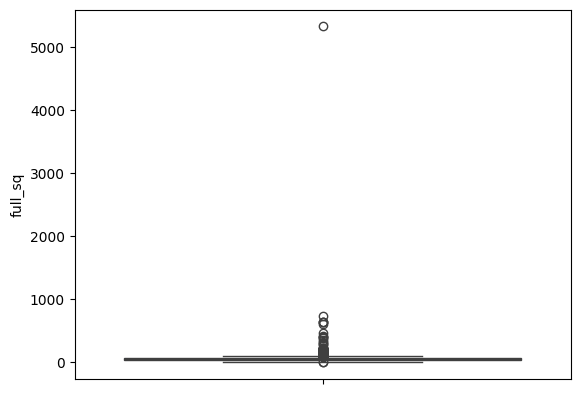

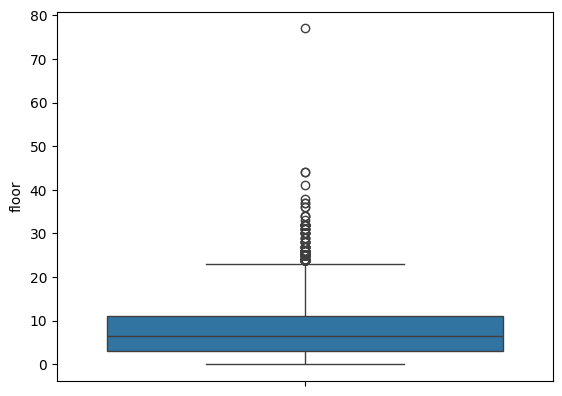

In [14]:
# Визуализация выбросов при помощи ящиков с усами. Для ускорения посмотрим 2 графика.
for column in ['full_sq', 'floor']:
    sns.boxplot(train[column])
    plt.show()
    

Видно, что есть некоторое количество выбросов, которые мы сейчас удалим.

In [15]:
train = train[train['state'] < 10]
train = train[(train['build_year'] > 1850) & (train['build_year'] <= 2015)]

#обработка выбросов при помощи z-показателя заменой на меданное значение
for column in numeric_columns:
    z_scores = (train[column] - train[column].mean()) / train[column].std()

    # Задаем порог для определения выбросов (обычно 3 или -3 для 99.7% данных)
    threshold = 3

    # Фильтрация данных для нахождения выбросов
    outliers = train[abs(z_scores) > threshold]

    # Замена выбросов на медианное значение
    median = train[column].median()
    train.loc[abs(z_scores) > threshold, column] = median

/tmp/ipykernel_27523/452840160.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  train.loc[abs(z_scores) > threshold, column] = median
/tmp/ipykernel_27523/452840160.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  train.loc[abs(z_scores) > threshold, column] = median
/tmp/ipykernel_27523/452840160.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  train.loc[abs(z_scores) > threshold, column] = median
/tmp/ipykernel_27523/452840160.py:16: FutureWarning: Setti

#### Базовый отбор признаков.
Оставим только те признаки, которые влияют на целевую переменную – цену. 

Будем это изучать благодаря анализу зависимостей между ценой и другими характеристиками.

In [16]:
len(numeric_columns)
# heatmap

46

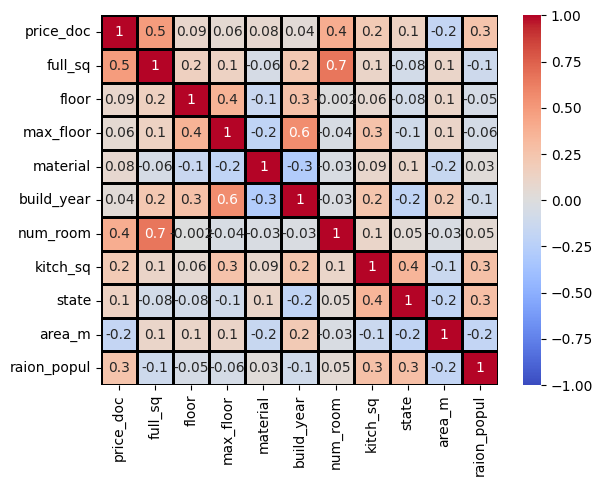

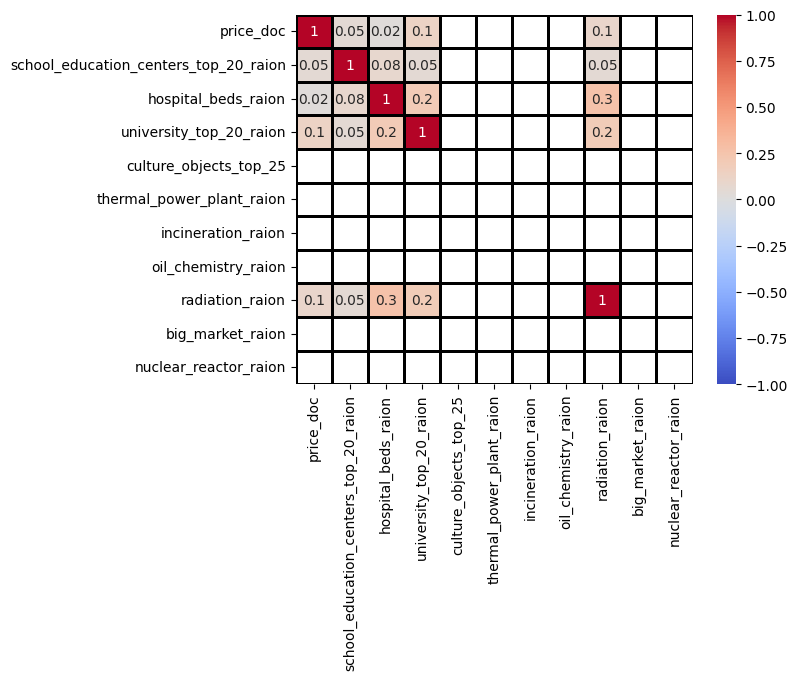

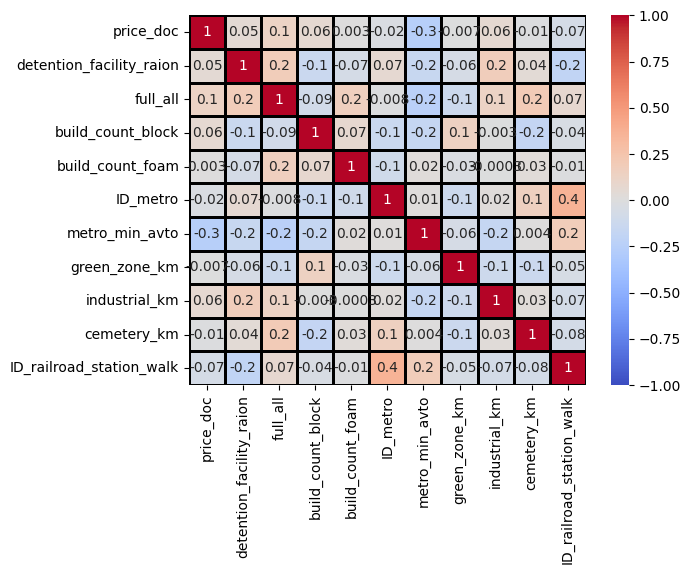

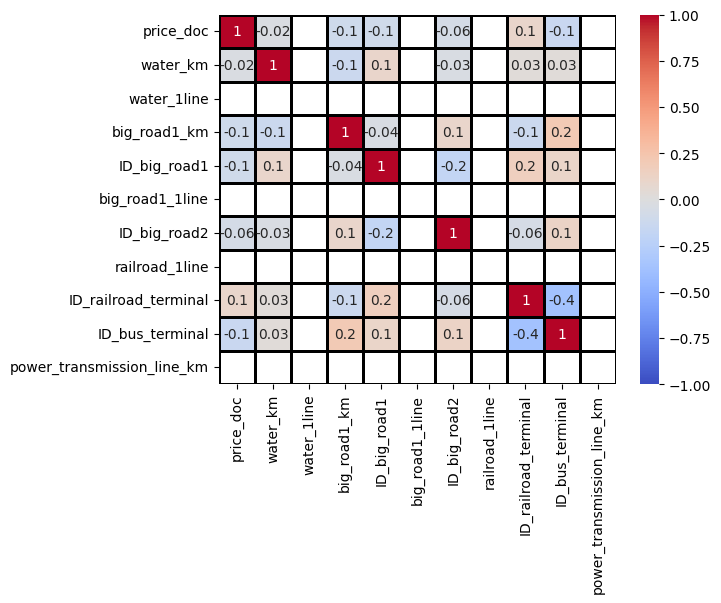

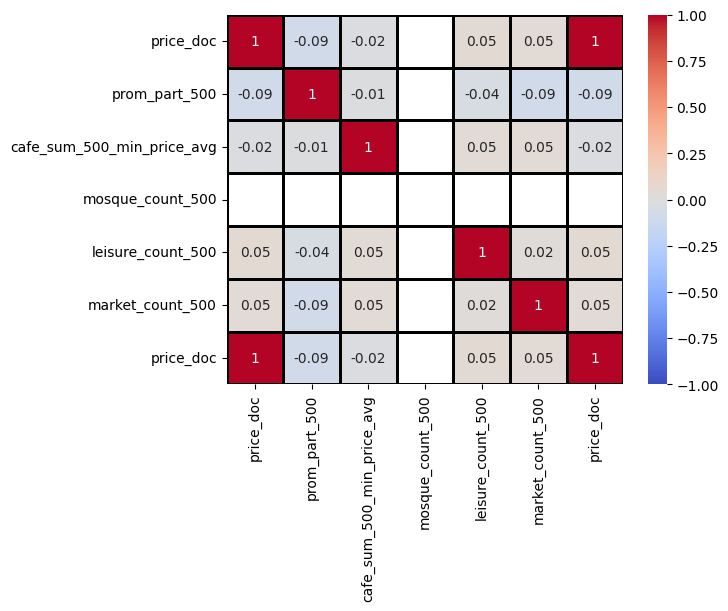

In [17]:
for i in range(5):
    sns.heatmap(train[['price_doc'] + numeric_columns[i * 10:i * 10 + 10]].corr(method='spearman'), annot=True, fmt='.1g', vmin=-1, vmax=1, center=0, cmap='coolwarm', linewidths=1,
                linecolor='black')
    plt.show()


Посмотрев на тепловую карту, мы решили выбрать признаки которую имеют неслабую связь с целевой харатеристикой.

In [18]:
categorial_columns

['timestamp', 'product_type', 'sub_area', 'ecology']

In [19]:
final_columns = [
    # целевая переменная.
    "price_doc", 
    # для соединения таблиц
    'timestamp',

    "full_sq", "num_room",
    "kitch_sq", "state", "area_m",
    "raion_popul", "university_top_20_raion",
    "radiation_raion", "full_all", "metro_min_avto",
    "big_road1_km",
]
train = train[final_columns]

### Обработка macro.csv

In [20]:
macro = pd.read_csv("data/macro.csv", skipinitialspace=True, sep=',')

macro.shape

(2484, 100)

In [21]:
macro.head()

,timestamp,oil_urals,gdp_quart,gdp_quart_growth,cpi,ppi,gdp_deflator,balance_trade,balance_trade_growth,usdrub,...,provision_retail_space_modern_sqm,turnover_catering_per_cap,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm
0,2010-01-01,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
1,2010-01-02,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
2,2010-01-03,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
3,2010-01-04,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.905,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
4,2010-01-05,76.1,NaN,NaN,asNA,NaN,NaN,NaN,NaN,29.836,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN


In [22]:
macro.isna().sum()

timestamp                         0
oil_urals                         0
gdp_quart                        90
gdp_quart_growth                 90
cpi                              30
                               ... 
bandwidth_sports                658
population_reg_sports_share    1023
students_reg_sports_share      1023
apartment_build                 658
apartment_fund_sqm              658
Length: 100, dtype: int64

In [23]:
macro.dtypes

timestamp                       object
oil_urals                      float64
gdp_quart                      float64
gdp_quart_growth               float64
cpi                             object
                                ...   
bandwidth_sports               float64
population_reg_sports_share    float64
students_reg_sports_share      float64
apartment_build                float64
apartment_fund_sqm             float64
Length: 100, dtype: object

Мы заметили, что некоторые числовые данные имеют тип object, из-за неправильного формата.
Исправим это с обработав их отдельно.

In [24]:
macro['child_on_acc_pre_school'] = pd.to_numeric(macro['child_on_acc_pre_school'].str.replace(',', '.'), errors='coerce')
macro['modern_education_share'] = pd.to_numeric(macro['modern_education_share'].str.replace(',', '.'), errors='coerce')
macro['old_education_build_share'] = pd.to_numeric(macro['old_education_build_share'].str.replace(',', '.'), errors='coerce')

In [25]:
categorial_columns = macro.dtypes[macro.dtypes == 'object'].index.to_list()
numeric_columns = macro.dtypes[macro.dtypes != 'object'].index.to_list()

print(categorial_columns)
print(numeric_columns)

['timestamp', 'cpi']
['oil_urals', 'gdp_quart', 'gdp_quart_growth', 'ppi', 'gdp_deflator', 'balance_trade', 'balance_trade_growth', 'usdrub', 'eurrub', 'brent', 'net_capital_export', 'gdp_annual', 'gdp_annual_growth', 'average_provision_of_build_contract', 'average_provision_of_build_contract_moscow', 'rts', 'micex', 'micex_rgbi_tr', 'micex_cbi_tr', 'deposits_value', 'deposits_growth', 'deposits_rate', 'mortgage_value', 'mortgage_growth', 'mortgage_rate', 'grp', 'grp_growth', 'income_per_cap', 'real_dispos_income_per_cap_growth', 'salary', 'salary_growth', 'fixed_basket', 'retail_trade_turnover', 'retail_trade_turnover_per_cap', 'retail_trade_turnover_growth', 'labor_force', 'unemployment', 'employment', 'invest_fixed_capital_per_cap', 'invest_fixed_assets', 'profitable_enterpr_share', 'unprofitable_enterpr_share', 'share_own_revenues', 'overdue_wages_per_cap', 'fin_res_per_cap', 'marriages_per_1000_cap', 'divorce_rate', 'construction_value', 'invest_fixed_assets_phys', 'pop_natural_in

#### Обработка отсутствующих значений.
Учитывая характер заполненных данных, мы решили запонить из несколько иным образом.
А именно заполнить предыдущими (следующими) значениями.

In [26]:
for column in numeric_columns:
    macro[column] = macro[column].ffill().bfill()

#### Обработка лишних значений.
Обработаем скоррелированные признаки подобно решению с train.

In [27]:
numeric_macro = macro[numeric_columns]

correlation_matrix = numeric_macro.corr()

correlated_features = set()
for column in range(len(correlation_matrix.columns)):
    for j in range(column):
        if abs(correlation_matrix.iloc[column, j]) > 0.5:
            colname = correlation_matrix.columns[column]
            correlated_features.add(colname)

# Удаляем скоррелированные признаки из DataFrame
macro = macro.drop(correlated_features, axis=1)
# переприсваиваем числовые колонки
numeric_columns = macro.dtypes[macro.dtypes != 'object'].index.to_list()

In [28]:
macro.shape

(2484, 8)

In [29]:
macro.head()

,timestamp,oil_urals,gdp_quart,cpi,balance_trade_growth,deposits_growth,rent_price_2room_eco,rent_price_1room_eco
0,2010-01-01,76.1,9995.8,NaN,14.1,0.002354,34.56,27.58
1,2010-01-02,76.1,9995.8,NaN,14.1,0.002354,34.56,27.58
2,2010-01-03,76.1,9995.8,NaN,14.1,0.002354,34.56,27.58
3,2010-01-04,76.1,9995.8,NaN,14.1,0.002354,34.56,27.58
4,2010-01-05,76.1,9995.8,asNA,14.1,0.002354,34.56,27.58


#### Выявление аномалий.
Проанализируем распределение данных. 

Если в них будут выбросы то это может негативно сказаться на итоговом качестве модели.

Решим задачу, как в случае с train.

In [30]:
#обработка выбросов при помощи z-показателя заменой на меданное значение
for column in numeric_columns:
    z_scores = (macro[column] - macro[column].mean()) / macro[column].std()

    # Задаем порог для определения выбросов (обычно 3 или -3 для 99.7% данных)
    threshold = 3

    # Фильтрация данных для нахождения выбросов
    outliers = macro[abs(z_scores) > threshold]

    # Замена выбросов на медианное значение
    median = macro[column].median()
    macro.loc[abs(z_scores) > threshold, column] = median

Количество оставшихся признаков 7. Все они имеют влияние на итоговое ценообразование, поэтому опустим этап отбора признаков.

## Объединение таблиц.
Объединим получившиеся таблицы в итоговую. Сохраним её, чтобы использовать при обучении.

In [31]:
train['timestamp'] = pd.to_datetime(train['timestamp'])
macro['timestamp'] = pd.to_datetime(macro['timestamp'])
result = pd.merge(train, macro, on='timestamp', how='inner')

In [32]:
result.to_csv('result.csv', index=False)